## Project Idea
Make up a text classification model, classifying student's responses into various rubric/requirements, this makes it easier for the professor/graders to make a gist of the submission and see the submission divided into the required goals for the assignment.
The dataset used here portrays essays from the IELTS writing section, and the need is to classify the essays into three rubrics being used for the grading of these essays, i.e., Task Response. coherence and correlation and Lexical resources (Vocubulary)


In [1]:
# performing imports
# python libraries
import os
import string
import re
from IPython.display import display, HTML
import warnings
import tqdm
from typing import List, Tuple, Dict

# Basic ML libraries and scikit learn libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib.colors import ListedColormap

# LDA libraries
import nltk
import gensim.corpora as corpora
import gensim
import gensim.models
from gensim.models import CoherenceModel
from gensim .models import TfidfModel
import spacy
import pyLDAvis
import pyLDAvis.gensim_models

# Bert and Pytorch libraries
import torch
import accelerate
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from torch.utils.data import DataLoader
from datasets import Dataset, Features, Value, Sequence
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BertModel, AdamW

In [2]:
# Getting current working directory
cwd = os.getcwd()
cwd

'D:\\My Work\\Computer Science Courses and Projects\\EMP_Work'

#### Task-1: Read the Dataset and manually label Task Response, Coherence and Lexical Resource

In [3]:
#Read CSV
Essay = pd.read_csv("ielts_writing_dataset.csv")

In [4]:
Essay.head()

,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0
3,2,Rich countries often give money to poorer coun...,Human beings are facing many challenges nowada...,NaN,NaN,NaN,NaN,NaN,5.5
4,1,The graph below shows the number of overseas v...,Information about the thousands of visits from...,NaN,NaN,NaN,NaN,NaN,7.0


In [5]:
#Getting rid of some unwanted columns, Dropping Task_Type and Question, as we will train the model on Essay text only, those two columns are useful when creating separate models for different model for different task types
Essay = Essay.drop(columns=['Task_Type','Question','Examiner_Commen','Range_Accuracy','Overall'])
Essay

,Essay,Task_Response,Coherence_Cohesion,Lexical_Resource
0,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN
1,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN
2,The left chart shows the population change hap...,NaN,NaN,NaN
3,Human beings are facing many challenges nowada...,NaN,NaN,NaN
4,Information about the thousands of visits from...,NaN,NaN,NaN
...,...,...,...,...
1430,Serious crimes need capital punishment so that...,NaN,NaN,NaN
1431,It is certainly said that learning is an ongoi...,NaN,NaN,NaN
1432,popular hobbies rather than their individual a...,NaN,NaN,NaN
1433,"Yes, I do feel that universities should have a...",NaN,NaN,NaN


In [6]:
# Split the dataset into training and testing
labeled_df, Test_Essays = train_test_split(Essay, test_size=0.2, random_state=42)

In [7]:
import pandas as pd
import re

# Expanded Keyword Lists
task_response_keywords = [
    'overall', 'in conclusion', 'to sum up', 'summary', 'to conclude', 'as a result',
    'overview', 'main trend', 'key trend', 'general pattern', 'it is clear that',
    'it can be seen', 'it is evident that', 'the graph shows', 'the chart illustrates',
    'according to the data', 'the data suggest', 'depicts', 'illustrates', 'shows',
    'describes', 'in general', 'over the period', 'as illustrated', 'in the figure',
    'the linear figure', 'bar chart', 'line graph', 'pie chart', 'diagram', 'table',
    'to summarize', 'as mentioned above', 'as stated earlier', 'mainly', 'it can be observed',
    'the results show', 'the data indicates', 'the chart highlights', 'the report shows',
    'the findings suggest', 'the data reveals', 'the trend suggests', 'the figures suggest',
    'the diagram shows', 'from the data, it is clear that', 'the graph indicates', 'in the final analysis'
]

coherence_cohesion_keywords = [
    'firstly', 'secondly', 'thirdly', 'then', 'after that', 'before that', 'next',
    'finally', 'in contrast', 'however', 'on the other hand', 'although', 'meanwhile',
    'while', 'similarly', 'subsequently', 'consequently', 'following this',
    'in addition', 'additionally', 'furthermore', 'moreover', 'at the start', 
    'in detail', 'at the end', 'identical pattern', 'continuous pattern', 'to begin with',
    'following this', 'alternatively', 'equally', 'more importantly'
]

lexical_resource_keywords = [
    'dramatically', 'sharply', 'steadily', 'significantly', 'substantially',
    'slightly', 'gradually', 'rapidly', 'moderately', 'plummet', 'soar',
    'rocket', 'decline', 'decrease', 'increase', 'peak', 'drop', 'rise',
    'fluctuate', 'stabilize', 'recovered', 'plummeted', 'rose', 'dipped',
    'trends', 'figures', 'statistics', 'growth', 'fall', 'surge', 'upward', 'downward',
    'increase in', 'decrease in', 'rise in', 'drop in', 'plunge', 'boom', 'skyrocket',
    'significant rise', 'significant fall', 'sharp increase', 'sharp decline',
    'level off', 'stabilize', 'maintain', 'rapid growth', 'slow growth', 'mild increase',
    'stable', 'constant', 'unchanged', 'proportion', 'percentage', 'rate', 'growth rate',
    'fall rate', 'upward trend', 'downward trend', 'figures', 'pattern', 'trend'
]

# 2. Regex sentence splitter
def simple_sentence_split(text):
    sentences = re.split(r'(?<=[.!?]) +', str(text))  # In case of NaN
    return sentences

# 3. Labeling function
def label_sentence(sentence):
    sentence_lower = sentence.lower()
    labels = {'Task_Response': 0, 'Coherence_Cohesion': 0, 'Lexical_Resource': 0}
    
    if any(keyword in sentence_lower for keyword in task_response_keywords):
        labels['Task_Response'] = 1
    
    if any(keyword in sentence_lower for keyword in coherence_cohesion_keywords):
        labels['Coherence_Cohesion'] = 1
    
    if any(keyword in sentence_lower for keyword in lexical_resource_keywords):
        labels['Lexical_Resource'] = 1
    
    return labels


# 5. Create DataFrame to store all labeled sentences
labeled_data = []

# 6. Process each essay
for idx, essay_text in enumerate(labeled_df["Essay"]):
    sentences = simple_sentence_split(essay_text)
    for sent in sentences:
        if sent.strip() == "":
            continue  # Skip empty sentences
        labels = label_sentence(sent)
        labeled_data.append({
            'Essay_ID': idx,
            'Sentence': sent.strip(),
            'Task_Response': labels['Task_Response'],
            'Coherence_Cohesion': labels['Coherence_Cohesion'],
            'Lexical_Resource': labels['Lexical_Resource'],
        })

# Final labeled dataset
labeled_df = pd.DataFrame(labeled_data)


# 8. Show
print(labeled_df.head())

# 9. Optional: Save to new CSV
# labeled_df.to_csv('labeled_sentences.csv', index=False)


   Essay_ID                                           Sentence  Task_Response  \
0         0  Usage of drugs is now common in our contempora...              0   
1         0  In this essay, i am going to discuss the cause...              0   
2         0  A lot of youths today, learnt this lifestyle f...              0   
3         0  For example, a teenager whose parents take coc...              0   
4         0  The chemical components of this drug are incre...              0   

   Coherence_Cohesion  Lexical_Resource  
0                   0                 0  
1                   0                 1  
2                   0                 0  
3                   0                 1  
4                   0                 0  


In [8]:
labeled_df

,Essay_ID,Sentence,Task_Response,Coherence_Cohesion,Lexical_Resource
0,0,Usage of drugs is now common in our contempora...,0,0,0
1,0,"In this essay, i am going to discuss the cause...",0,0,1
2,0,"A lot of youths today, learnt this lifestyle f...",0,0,0
3,0,"For example, a teenager whose parents take coc...",0,0,1
4,0,The chemical components of this drug are incre...,0,0,0
...,...,...,...,...,...
10569,1146,"In a contrast, a continuous decline on purchas...",0,0,1
10570,1147,The bar chart illustrates information on the n...,1,1,1
10571,1147,"Also, the demand response for accidents was mo...",0,1,0
10572,1147,"Although, the number of recorded injuries in t...",0,1,1


In [9]:
import pandas as pd

# Assuming you have the 'labeled_df' DataFrame loaded
# Filter out rows where all the specified columns have a value of zero
filtered_df = labeled_df[
    (labeled_df['Task_Response'] != 0) | 
    (labeled_df['Coherence_Cohesion'] != 0) | 
    (labeled_df['Lexical_Resource'] != 0)
]

labeled_df = filtered_df.reset_index(drop=True)

In [10]:
labeled_df

,Essay_ID,Sentence,Task_Response,Coherence_Cohesion,Lexical_Resource
0,0,"In this essay, i am going to discuss the cause...",0,0,1
1,0,"For example, a teenager whose parents take coc...",0,0,1
2,0,"A recent study, showed that 75% of young adult...",1,0,1
3,0,Psychotherapy should also be recommended.\nTo ...,1,1,1
4,1,The provided barr chart depicts the proportion...,1,0,1
...,...,...,...,...,...
5070,1146,"Then, a sharp increase in the consumption of h...",0,1,1
5071,1146,"In a contrast, a continuous decline on purchas...",0,0,1
5072,1147,The bar chart illustrates information on the n...,1,1,1
5073,1147,"Also, the demand response for accidents was mo...",0,1,0


In [11]:
print(labeled_df.dtypes)

Essay_ID               int64
Sentence              object
Task_Response          int64
Coherence_Cohesion     int64
Lexical_Resource       int64
dtype: object


C:\Users\ritvi\AppData\Local\Temp\ipykernel_7876\4035380066.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labeled_df, x='Task_Response', palette='Set2')
C:\Users\ritvi\AppData\Local\Temp\ipykernel_7876\4035380066.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labeled_df, x='Coherence_Cohesion', palette='Set2')
C:\Users\ritvi\AppData\Local\Temp\ipykernel_7876\4035380066.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labeled_df, x='Lexical_Resource', palette='Set2')


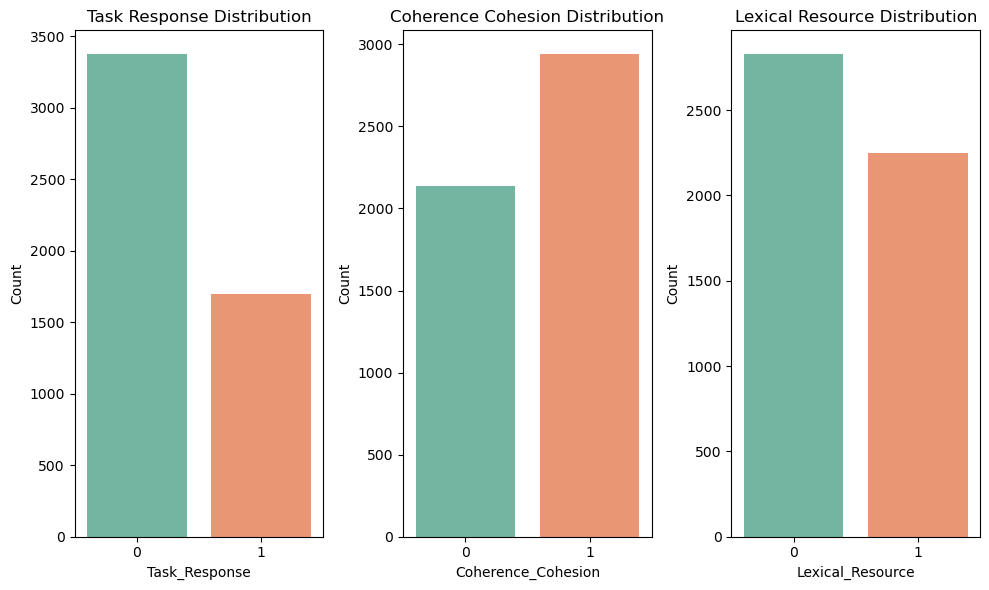

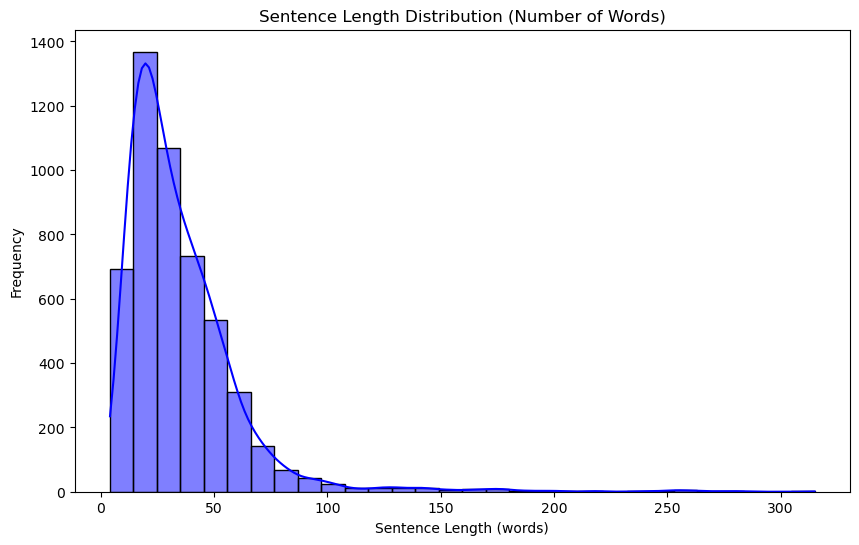

Missing Values in each column:
Essay_ID              0
Sentence              0
Task_Response         0
Coherence_Cohesion    0
Lexical_Resource      0
sentence_length       0
dtype: int64


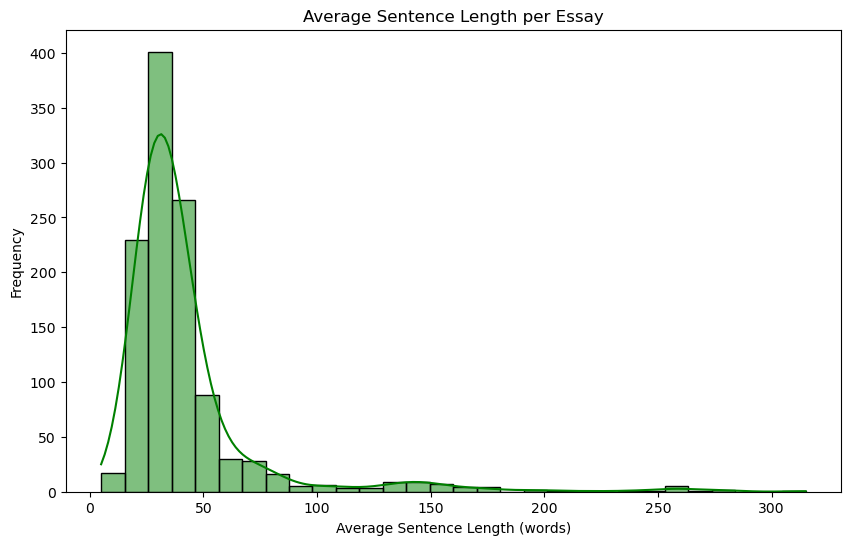

Sample Essays and Their Labels:
   Essay_ID                                           Sentence  Task_Response  \
0         0  In this essay, i am going to discuss the cause...              0   
1         0  For example, a teenager whose parents take coc...              0   
2         0  A recent study, showed that 75% of young adult...              1   
3         0  Psychotherapy should also be recommended.\nTo ...              1   
4         1  The provided barr chart depicts the proportion...              1   

   Coherence_Cohesion  Lexical_Resource  
0                   0                 1  
1                   0                 1  
2                   0                 1  
3                   1                 1  
4                   0                 1  


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming labeled_df is already defined
def analyze_labeled_df(labeled_df):
    # 1. Class Distribution of Task_Response, Coherence_Cohesion, Lexical_Resource
    plt.figure(figsize=(10, 6))
    
    # Plot Task_Response distribution
    plt.subplot(131)
    sns.countplot(data=labeled_df, x='Task_Response', palette='Set2')
    plt.title('Task Response Distribution')
    plt.xlabel('Task_Response')
    plt.ylabel('Count')
    
    # Plot Coherence_Cohesion distribution
    plt.subplot(132)
    sns.countplot(data=labeled_df, x='Coherence_Cohesion', palette='Set2')
    plt.title('Coherence Cohesion Distribution')
    plt.xlabel('Coherence_Cohesion')
    plt.ylabel('Count')

    # Plot Lexical_Resource distribution
    plt.subplot(133)
    sns.countplot(data=labeled_df, x='Lexical_Resource', palette='Set2')
    plt.title('Lexical Resource Distribution')
    plt.xlabel('Lexical_Resource')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    # 2. Essay Sentence Length Distribution (word count per sentence)
    labeled_df['sentence_length'] = labeled_df['Sentence'].apply(lambda x: len(x.split()))

    # Plot distribution of sentence lengths
    plt.figure(figsize=(10, 6))
    sns.histplot(labeled_df['sentence_length'], kde=True, color='blue', bins=30)
    plt.title('Sentence Length Distribution (Number of Words)')
    plt.xlabel('Sentence Length (words)')
    plt.ylabel('Frequency')
    plt.show()

    # 3. Missing Values
    missing_values = labeled_df.isnull().sum()
    print(f"Missing Values in each column:\n{missing_values}")

    # 4. Aggregate essay-level statistics:
    # Aggregating by Essay_ID: Calculating average sentence length per essay
    essay_stats = labeled_df.groupby('Essay_ID')['sentence_length'].agg(['mean', 'std']).reset_index()

    # Plot the average sentence length for each essay
    plt.figure(figsize=(10, 6))
    sns.histplot(essay_stats['mean'], kde=True, color='green', bins=30)
    plt.title('Average Sentence Length per Essay')
    plt.xlabel('Average Sentence Length (words)')
    plt.ylabel('Frequency')
    plt.show()

    # 5. Sample Essays
    print("Sample Essays and Their Labels:")
    print(labeled_df[['Essay_ID', 'Sentence', 'Task_Response', 'Coherence_Cohesion', 'Lexical_Resource']].head(5))

# Perform analysis
analyze_labeled_df(labeled_df)


### Train first transformer (For better context extraction)

In [13]:
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import pandas as pd


# Split the dataset into training and testing
train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=42)

# Load tokenizer and pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Define Dataset class
class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sentence = self.dataframe.iloc[idx]['Sentence']
        
        # Tokenize the sentence and truncate/pad to max_length
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,  # Attention mask to focus on actual tokens
            return_tensors='pt',  # Return PyTorch tensors
        )
        
        # Prepare the labels
        task_response = torch.tensor(self.dataframe.iloc[idx]['Task_Response'], dtype=torch.float)
        coherence_cohesion = torch.tensor(self.dataframe.iloc[idx]['Coherence_Cohesion'], dtype=torch.float)
        lexical_resource = torch.tensor(self.dataframe.iloc[idx]['Lexical_Resource'], dtype=torch.float)

        label = torch.stack([task_response, coherence_cohesion, lexical_resource])  # Stack labels into one tensor

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

# Create DataLoader for batching
train_dataset = EssayDataset(dataframe=train_df, tokenizer=tokenizer, max_length=128)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = EssayDataset(dataframe=test_df, tokenizer=tokenizer, max_length=128)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)




# Set up Trainer with BERT model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,                     # The model to train
    args=training_args,              # Training arguments
    train_dataset=train_dataset,     # Training dataset
    eval_dataset=test_dataset,       # Evaluation dataset
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned BERT model
model.save_pretrained('./fine_tuned_bert')
tokenizer.save_pretrained('./fine_tuned_bert')


C:\Users\ritvi\miniconda3\envs\EMP_env\lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificat

Step,Training Loss
500,0.409900
1000,0.193300


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json
Model weights saved in ./results\checkpoint-1000\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Configuration saved in ./fine_tuned_bert\config.json
Model weights saved in ./fine_tuned_bert\pytorch_model.bin
tokenizer config file saved in ./fine_tuned_bert\tokenizer_config.json
Special tokens file saved in ./fine_tuned_bert\special_tokens_map.json


('./fine_tuned_bert\\tokenizer_config.json',
 './fine_tuned_bert\\special_tokens_map.json',
 './fine_tuned_bert\\vocab.txt',
 './fine_tuned_bert\\added_tokens.json')

### Fine tuning the second model

In [14]:
from transformers import BertTokenizer, BertModel, AdamW
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset

# Load models and tokenizers
model_1 = BertModel.from_pretrained('./fine_tuned_bert')
tokenizer_1 = BertTokenizer.from_pretrained('./fine_tuned_bert')

model_2 = BertModel.from_pretrained('bert-base-uncased')
tokenizer_2 = BertTokenizer.from_pretrained('bert-base-uncased')

# Simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, embeddings):
        return self.fc(embeddings)

# Instantiate classifier
classifier_model = SimpleClassifier(input_dim=768, num_classes=3)

# Function to get embeddings from the first transformer
def get_first_transformer_embeddings(sentence):
    if isinstance(sentence, torch.Tensor):
        encoding = {'input_ids': sentence}
    else:
        encoding = tokenizer_1.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

    with torch.no_grad():
        outputs = model_1(**encoding)

    embeddings = outputs.last_hidden_state
    return embeddings

# Fine-tune second transformer
def fine_tune_second_transformer(first_transformer_output, attention_mask):
    outputs = model_2(inputs_embeds=first_transformer_output, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state
    return last_hidden_state[:, 0, :]  # [CLS] token

# Optimizer with gradient clipping and lower learning rate
optimizer = AdamW(model_2.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

# Assuming `train_dataloader` is defined
# To get 10% of the dataset, we can use the following approach:
# Get a subset of 10% of the indices from the train dataset
dataset_size = len(train_dataloader.dataset)
subset_size = int(dataset_size * 0.1)  # 10% of the dataset size
subset_indices = torch.randperm(dataset_size).tolist()[:subset_size]

# Create a new DataLoader using the subset
train_subset = Subset(train_dataloader.dataset, subset_indices)
train_subset_dataloader = DataLoader(train_subset, batch_size=train_dataloader.batch_size, shuffle=True)

# Training loop with mixed precision
scaler = torch.cuda.amp.GradScaler()  # For mixed precision training

for epoch in range(1):
    model_2.train()
    classifier_model.train()
    for batch in tqdm(train_subset_dataloader, desc="Training Progress", unit="batch"):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']

        # Get embeddings from the first transformer (fine-tuned BERT)
        first_transformer_output = get_first_transformer_embeddings(input_ids)

        # Fine-tune the second transformer
        second_transformer_output = fine_tune_second_transformer(first_transformer_output, attention_mask)

        # Pass the output to the classifier
        logits = classifier_model(second_transformer_output)

        # Compute loss
        loss = nn.MSELoss()(logits, batch['labels'])

        # Backpropagation with mixed precision
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    scheduler.step()


loading configuration file ./fine_tuned_bert\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file ./fine_tuned_bert

In [15]:
import numpy as np
import torch
from tqdm import tqdm

# Function to extract features (embeddings) from both models
def extract_embeddings(data_loader, model_1, model_2, tokenizer_1, tokenizer_2):
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Features", unit="batch"):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            
            # Get embeddings from model_1 (fine-tuned BERT)
            first_transformer_output = get_first_transformer_embeddings(input_ids)
            
            # Extract [CLS] token from first model (batch_size, embedding_size)
            first_model_embeddings = first_transformer_output[:, 0, :].cpu().numpy()
            
            # Fine-tune second transformer (model_2 - BERT)
            second_transformer_output = fine_tune_second_transformer(first_transformer_output, attention_mask)
            second_model_embeddings = second_transformer_output.cpu().numpy()  # Extract [CLS] token or final embeddings
            
            # Combine both embeddings
            combined_embeddings = np.concatenate((first_model_embeddings, second_model_embeddings), axis=1)
            
            all_embeddings.append(combined_embeddings)
            all_labels.append(labels.cpu().numpy())
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_embeddings, all_labels


In [16]:
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

# ------------------------ #
# Extract embeddings from Model 1
# ------------------------ #
def extract_embeddings_from_model_1(data_loader, model_1, device='cuda'):
    model_1.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Embeddings from Model 1", unit="batch"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model_1(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token

            all_embeddings.append(cls_embeddings.cpu())
            all_labels.append(labels.cpu())
    
    all_embeddings = torch.cat(all_embeddings).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    return all_embeddings, all_labels

# ------------------------ #
# Classify using Model 2 + Classifier Head
# ------------------------ #
def classify_using_model_2_with_embeddings(embeddings, model_2, classifier_model, device='cuda'):
    model_2.eval()
    classifier_model.eval()
    
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)
    embeddings_tensor = embeddings_tensor.unsqueeze(1)  # Add dummy seq_length dimension

    attention_mask = torch.ones(embeddings_tensor.size()[:-1], dtype=torch.long).to(device)
    
    with torch.no_grad():
        outputs = model_2(inputs_embeds=embeddings_tensor, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        logits = classifier_model(pooled_output)
        predictions = torch.argmax(logits, dim=-1)
        
    return predictions.cpu().numpy()

# ------------------------ #
# Main Evaluation Pipeline
# ------------------------ #
def evaluate(test_dataloader, model_1, model_2, classifier_model, device='cuda'):
    model_1.eval()
    model_2.eval()
    classifier_model.eval()


    # 3. Metrics
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(report)






In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 1. Extract embeddings
test_embeddings, true_labels = extract_embeddings_from_model_1(test_dataloader, model_1, device=device)

# 👉 Convert true_labels if needed
if len(true_labels.shape) > 1 and true_labels.shape[1] > 1:
    true_labels = np.argmax(true_labels, axis=1)

# 2. Classify
predictions = classify_using_model_2_with_embeddings(test_embeddings, model_2, classifier_model, device=device)


Extracting Embeddings from Model 1: 100%|█████████████████████████████████████████| 254/254 [00:16<00:00, 15.20batch/s]


In [21]:
# Example usage
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)
model_2.to(device)
classifier_model.to(device)

evaluate(test_dataloader, model_1, model_2, classifier_model, device)

Accuracy: 82.07%
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       344
           1       0.85      0.94      0.89       499
           2       0.69      0.78      0.73       172

    accuracy                           0.82      1015
   macro avg       0.80      0.80      0.79      1015
weighted avg       0.82      0.82      0.82      1015



In [22]:
import torch
from IPython.display import display, HTML
import re

# Define colors for each label
label_colors = {
    0: '#ADD8E6',  # Light Blue, task response
    1: '#90EE90',  # Light Green, cohesion
    2: '#FFB6C1',  # Light Pink, lexical resources
}

# Function to split essays into sentences (simple version)
def split_into_sentences(text):
    sentences = re.split(r'(?<=[.!?]) +', text)
    return [s for s in sentences if s]

# Function to predict label for one sentence
def predict_label(sentence, model_1, model_2, classifier_model, tokenizer_1, device='cuda'):
    model_1.eval()
    model_2.eval()
    classifier_model.eval()

    encoding = tokenizer_1.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    ).to(device)

    with torch.no_grad():
        outputs1 = model_1(**encoding)
        first_transformer_output = outputs1.last_hidden_state  # (1, seq_len, hidden_dim)

        # Pass embeddings into model_2
        outputs2 = model_2(inputs_embeds=first_transformer_output, attention_mask=encoding['attention_mask'])
        second_transformer_output = outputs2.last_hidden_state[:, 0, :]  # CLS token

        logits = classifier_model(second_transformer_output)
        predicted_label = torch.argmax(logits, dim=-1).item()
    
    return predicted_label

# Function to highlight sentences according to their label
def highlight_essay(essay_text, model_1, model_2, classifier_model, tokenizer_1, device='cuda'):
    sentences = split_into_sentences(essay_text)
    highlighted_sentences = []

    for sentence in sentences:
        label = predict_label(sentence, model_1, model_2, classifier_model, tokenizer_1, device)
        color = label_colors.get(label, '#FFFFFF')  # Default to white if label unknown
        highlighted_sentence = f'<span style="background-color:{color}; padding:2px; border-radius:4px;">{sentence}</span>'
        highlighted_sentences.append(highlighted_sentence)
    
    highlighted_essay = ' '.join(highlighted_sentences)
    return highlighted_essay

# 🚀 Now go through 10 essays and highlight them
def display_highlighted_essays(Test_Essays, model_1, model_2, classifier_model, tokenizer_1, device='cuda'):
    for idx, essay in enumerate(Test_Essays["Essay"][:10]):  # Take first 10 essays
        highlighted = highlight_essay(essay, model_1, model_2, classifier_model, tokenizer_1, device)
        display(HTML(f"<h3>Essay {idx+1}</h3><p>{highlighted}</p>"))



In [23]:
display_highlighted_essays(Test_Essays, model_1, model_2, classifier_model, tokenizer_1, device='cuda')


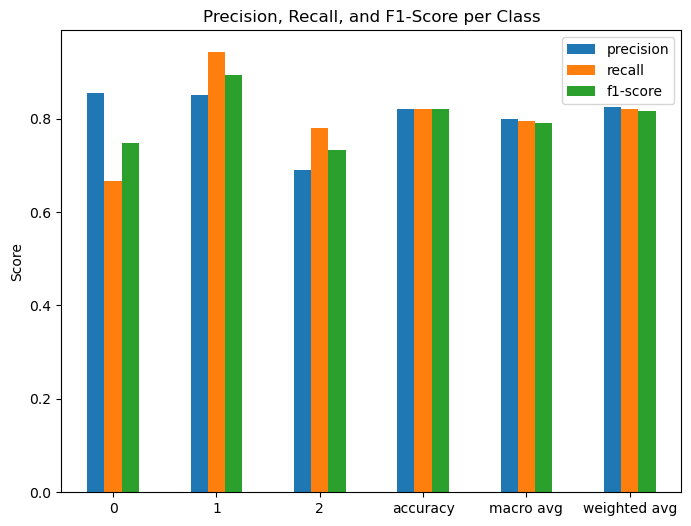

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

# Assuming `true_labels` and `predictions` are already available from your evaluation
# 1. Confusion Matrix

def plot_confusion_matrix(true_labels, predictions, labels):
    cm = confusion_matrix(true_labels, predictions, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# 2. Precision, Recall, F1 Score Plot
def plot_metrics(metrics_report):
    metrics_df = pd.DataFrame(metrics_report).T
    metrics_df = metrics_df[['precision', 'recall', 'f1-score']]
    metrics_df.plot(kind='bar', figsize=(8, 6))
    plt.title('Precision, Recall, and F1-Score per Class')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.show()

# Assuming `classification_report` (from sklearn) is used to get precision, recall, f1-score
metrics_report = classification_report(true_labels, predictions, output_dict=True)
plot_metrics(metrics_report)
